In [1]:
from skimage import io, feature
from scipy import ndimage
import numpy as np
from aicsimageio import AICSImage
import cv2 as cv
from matplotlib import pyplot as plt

# Bead Alignment Notebook
 
__How to Use:__
 
__Setup:__
1. Copy the Base Image path into the variable `base_image_path`
2. Copy the unaligned newly taken image path into the variable `unaligned_new_image_path`
3. Choose a scene to look at and copy it into the variable `scene`, This step is optional. If no scene is chosen than AICSImage I0 defaults to the first scene
 
__To Run:__ Simply run all cells after you have entered the above information. The last cell will print out the shift between the new Images. This coordinate shift [x,y] can be entered into the GUI in order to adjust the camera.
 
look at the output image at the bottom of this notebook. The Image consists of the two different rounds set side by side. on the left side of the image you will see the newly acquired image with a section selected from the center (250 pixel padding). This section is used as a template to search the original image. The right hand side of the output image is the original image with the best matched section that looks like the template.
 
To check that this code ran successfully look at the two side by side images (stitched together and at the bottom of this notebook) if the borders of the drawn rectangles appear to be proportional distances from key features (Beads) then the alignment has been successful.





### Fields to Edit
note: path formatting may change with different systems. Enter whatever path formatting you normally use for your system.

EX. <br>

    Linux: '/allen/aics/microscopy.... ' <br>
    Windows: r'C:\allen\aics\microscopy...' <br>
    Mac: '/allen/aics/microscopy.... ' <br>

In [2]:
base_image_path = '/allen/aics/microscopy/Data/RnD_Sandbox/Alignment Test 20220913/20220913_20X_round0.czi'
unaligned_new_image_path = '/allen/aics/microscopy/Data/RnD_Sandbox/Alignment Test 20220913/20220913_20X_round1_unaligned.czi'
scene = '' # Example 'P1-B2'

### Function - (No Editing Required)

In [3]:
def get_shift(raw_image_path_one, raw_image_path_two, scene = '', eval_method = 'cv.TM_CCOEFF_NORMED'):
    
    # Read in Images as AICSImage
    img1 = AICSImage(raw_image_path_one)
    img2 = AICSImage(raw_image_path_two)

    # AICS Image defaults to the first scene
    if scene != '':
        img1.set_scene(scene)
        img2.set_scene(scene)
    
    # Building images from AICSImage, C and Z can be varied if image is not accurate  
    temp_image_1 = img1.get_image_data("XY", C=0, Z=0, S=0, T=0)
    temp_image_2 = img2.get_image_data("XY", C=0, Z=0, S=0, T=0)
    
    
    # Image Formatting
    temp_image_1  = cv.normalize(temp_image_1 , None, 0, 255, cv.NORM_MINMAX).astype("uint8")
    temp_image_2 = cv.normalize(temp_image_2, None, 0, 255, cv.NORM_MINMAX).astype("uint8")
    img1_rectangle = temp_image_1.copy()
    img2_rectangle = temp_image_2.copy()
    
    
    # Creating a padded template (Padding 250 Pixels)
    template = temp_image_2[250:-250, 250:-250]
    w, h = template.shape[::-1]
    
    #Evaluate matches
    method = eval(eval_method)
    res = cv.matchTemplate(temp_image_1,template,method)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)

    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc

    # Determining shift  
    bottom_right = (top_left[0] + w, top_left[1] + h)
    shift = [top_left[0] - 250, top_left[1] - 250]

    # Empty drawing params for the opencv drawMatches function 
    draw_params = dict(matchColor = (255,0,0),
            singlePointColor = None,
            matchesMask = [], 
            flags = 2)

    # Drawing Rectangles for visual confirmation 
    img1_rectangle = cv.rectangle(img1_rectangle, top_left, bottom_right, 255, 2)
    img2_rectangle = cv.rectangle(img2_rectangle,[250,250], [img2_rectangle.shape[1] - 250, img2_rectangle.shape[0] - 250], 255, 2)

    # Joining into one image 
    img3 = cv.drawMatches(img2_rectangle,[],img1_rectangle,[],[],None, **draw_params)

    plt.imshow(img3, "gray", aspect=1)
    #plt.set_title("Scene: "+ scene + "  Shift: " + str(shift))

    # adjust for rotation by AicsImage
    adjusted_shift = [-shift[1],shift[0]]

    return adjusted_shift

Shift: [88, 20]


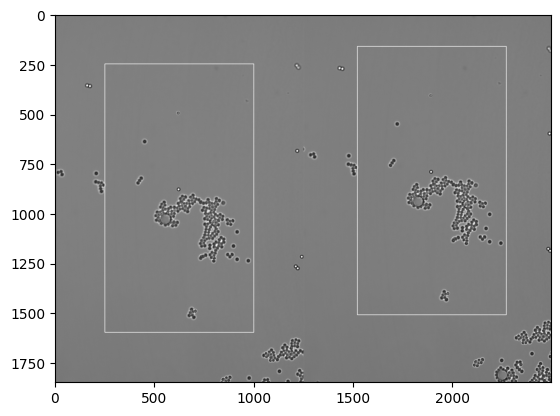

In [4]:
print("Shift: " + str(get_shift(base_image_path,unaligned_new_image_path, scene)))